<a id="section-top"></a>

# Table of Contents

**0)** [Introduction](#section-zero)

**1)** [Basic Informations about Data](#section-one)

**2)** [Basic Visualization & Checking Outliers](#section-two)

**3)** [Checking Normality](#section-three)

- [Q-Q Plot](#section-three-one)

- [Checking Normality with Statistical Tests](#section-three-two)

**4)** [Comparing Groups: sum_gamerounds](#section-four)

**5)** [Comparing Groups: retention days](#section-five)

- [Test Results](#section-five-one)

**6)** [Conclusion](#section-six)

<a id="section-zero"></a>
# 0. Introduction

In this notebook, I simply apply statistical tests for comparing relations between variables and groups.

# Project Description
Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three" style puzzle game where the player must connect tiles of the same color in order to clear the board and win the level. It also features singing cats. We're not kidding!

As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. In this project, we will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on player retention.

To complete this project, you should be comfortable working with pandas DataFrames and with using the pandas plot method. You should also have some understanding of hypothesis testing and bootstrap analysis.

*https://app.datacamp.com/learn/projects/184

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

import warnings

[take me to the top](#section-top)

<a id="section-one"></a>

# 1. Basic Informations about Data

In [2]:
df = pd.read_csv("../input/mobile-games-ab-testing/cookie_cats.csv")

print(df.shape, "\n")

display(df.head())

(90189, 5) 



,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


# Variables
- **userid** - a unique number that identifies each player.
- **version** - whether the player was put in the control group (gate_30 - a gate at level 30) or the test group (gate_40 - a gate at level 40).
- **sum_gamerounds** - the number of game rounds played by the player during the first week after installation
- **retention_1** - did the player come back and play 1 day after installing?
- **retention_7** - did the player come back and play 7 days after installing?

*https://www.kaggle.com/yufengsui/datacamp-project-mobile-games-a-b-testing

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [4]:
df.describe(include = "all")

,userid,version,sum_gamerounds,retention_1,retention_7
count,9.018900e+04,90189,90189.000000,90189,90189
unique,NaN,2,NaN,2,2
top,NaN,gate_40,NaN,False,False
freq,NaN,45489,NaN,50036,73408
mean,4.998412e+06,NaN,51.872457,NaN,NaN
std,2.883286e+06,NaN,195.050858,NaN,NaN
min,1.160000e+02,NaN,0.000000,NaN,NaN
25%,2.512230e+06,NaN,5.000000,NaN,NaN
50%,4.995815e+06,NaN,16.000000,NaN,NaN
75%,7.496452e+06,NaN,51.000000,NaN,NaN


In [5]:
df.isnull().sum().sum()

0

In [6]:
df[df.userid.duplicated()]

,userid,version,sum_gamerounds,retention_1,retention_7


[take me to the top](#section-top)

<a id="section-two"></a>
# 2. Basic Visualization & Checking Outliers

In this problem, we have an extreme outlier that can be hurt our analysis. Let's examine it.

In [7]:
df.groupby("version").sum_gamerounds.describe().round(3)

,count,mean,std,min,25%,50%,75%,max
version,,,,,,,,
gate_30,44700.0,52.456,256.716,0.0,5.0,17.0,50.0,49854.0
gate_40,45489.0,51.299,103.294,0.0,5.0,16.0,52.0,2640.0


Here, we can see, for gate_30 version, 75% quantile is 50 and, our max value for this series is nearly 50k. It could be an typo, we should remove it.

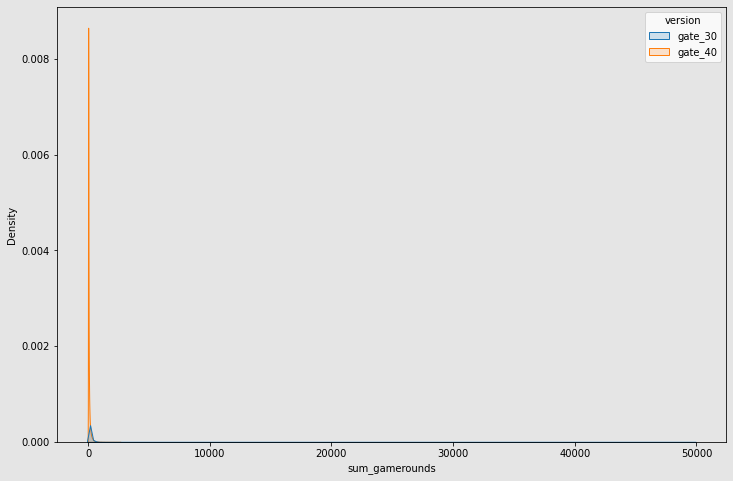

In [8]:
fig, ax = plt.subplots(figsize = (12, 8), facecolor = "#e5e5e5")
ax.set_facecolor("#e5e5e5")

sns.kdeplot(data = df, x = "sum_gamerounds", ax = ax, hue = "version", alpha = 0.2, fill = True)
plt.show()

Above graph is sum_gamerounds distribution for version. Outlier makes our plot unclear.

In [9]:
df.sort_values("sum_gamerounds", ascending = False).head()

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,False,True
7912,871500,gate_30,2961,True,True
29417,3271615,gate_40,2640,True,False
43671,4832608,gate_30,2438,True,True
48188,5346171,gate_40,2294,True,True


In [10]:
print(f"Total observations before removing outlier(s?) {df.shape[0]}")

df = df[df.sum_gamerounds < 3000]

print(f"\nTotal observations after removing outlier(s?) {df.shape[0]}")

Total observations before removing outlier(s?) 90189

Total observations after removing outlier(s?) 90188


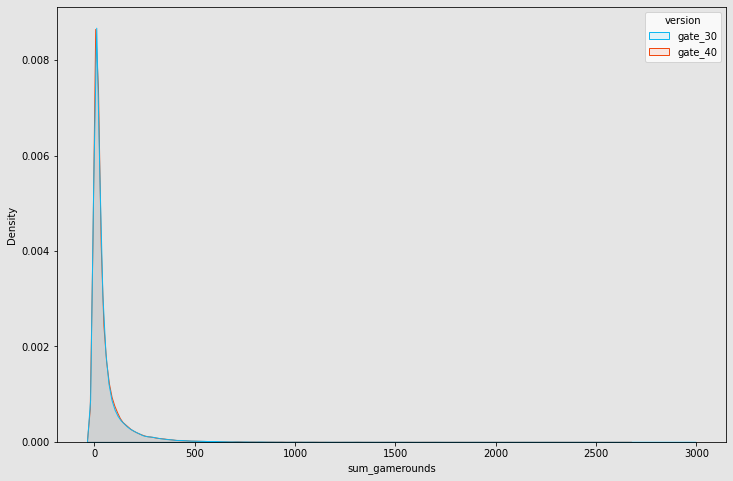

In [11]:
fig, ax = plt.subplots(figsize = (12, 8), facecolor = "#e5e5e5")
ax.set_facecolor("#e5e5e5")

sns.kdeplot(data = df, x = "sum_gamerounds", ax = ax, 
            palette = ["#0EB8F1", "#F1480F"], hue = "version", alpha = 0.1, fill = True)

plt.show()

After removing that outlier, our grap is more understandable. Basically, sum_gamerounds distribution for gate 30 and gate 40 versions are similar. Most of sum_gamerounds is between 0-250. The distribution is right skewed.

<AxesSubplot:ylabel='sum_gamerounds'>

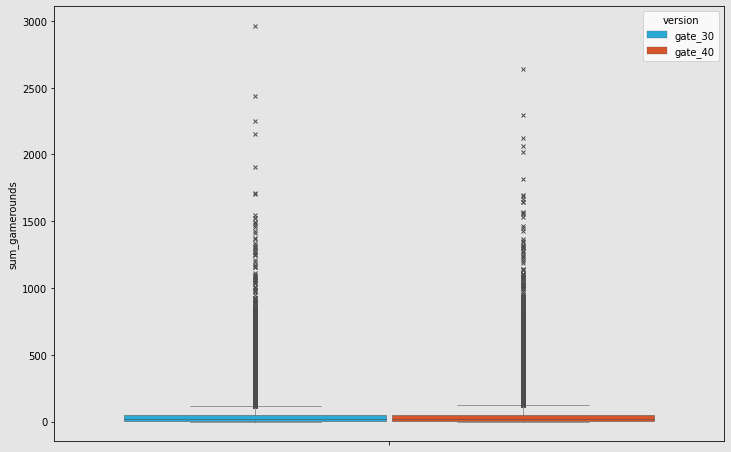

In [12]:
fig, ax = plt.subplots(figsize = (12, 8), facecolor = "#e5e5e5")
ax.set_facecolor("#e5e5e5")

sns.boxplot(data = df, y = "sum_gamerounds", hue = "version", 
            ax = ax, x = [""] * len(df), 
            palette = ["#0EB8F1", "#F1480F"], linewidth = 0.5, 
            flierprops = dict(marker = "x", markersize = 3.5))

[take me to the top](#section-top)

<a id="section-three"></a>
# 3. Checking Normality

<a id="section-three-one"></a>
## 3.1 Q-Q Plot for Normality

Q-Q plot shortly shows distribution of our data points against expected normal distribution.

If it is normal, values are near the 45° line.

For better understand, we have 9 qq-plot that belong to 9 different normal distributed series, created with numpy's random generator. Series are same mu and sigma, 0 and 1.

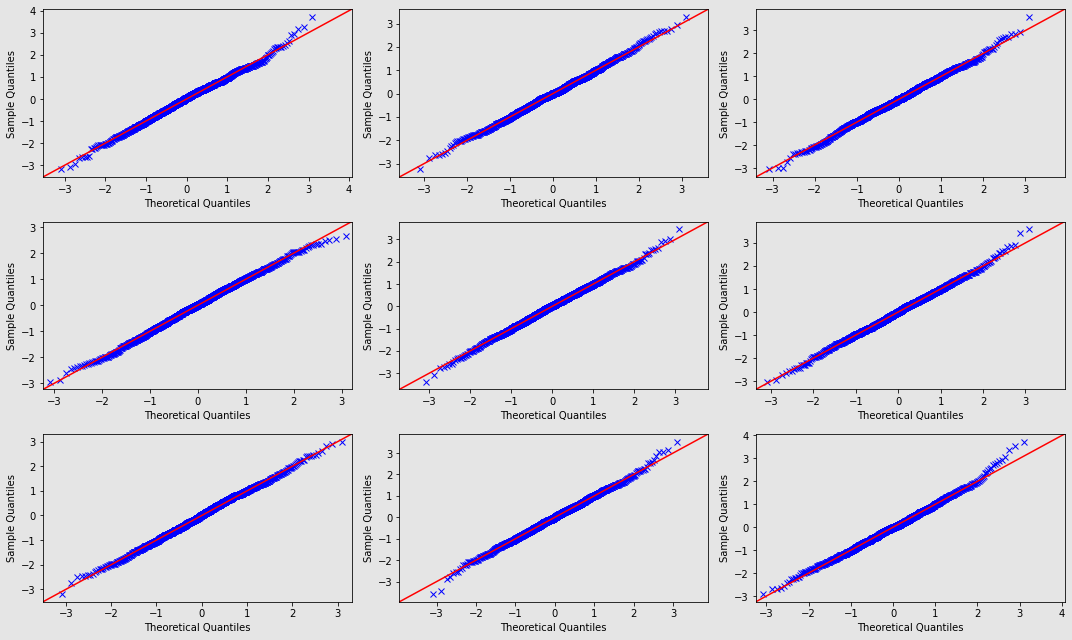

In [13]:
fig = plt.figure(1, figsize=(15, 9), facecolor = "#E5E5E5")

for i in range(1, 10):
    
    normal_series = np.random.normal(0, 1, 1000)
    
    ax = fig.add_subplot(3, 3, i)
    
    with warnings.catch_warnings():
        
        warnings.simplefilter("ignore")
        sm.qqplot(normal_series, ax = ax, marker = "x", line = "45", fit = True)  
        
    ax.set_facecolor("#e5e5e5")

plt.tight_layout()
plt.show()

As you can see, the values are lie over the straight line. If we have normal distributed data, we expect that behaivor.

In our example, sum_gamerounds variable has right skewed distribution. We already interpret that its distribution is not normal, but let's see its qq-plot.

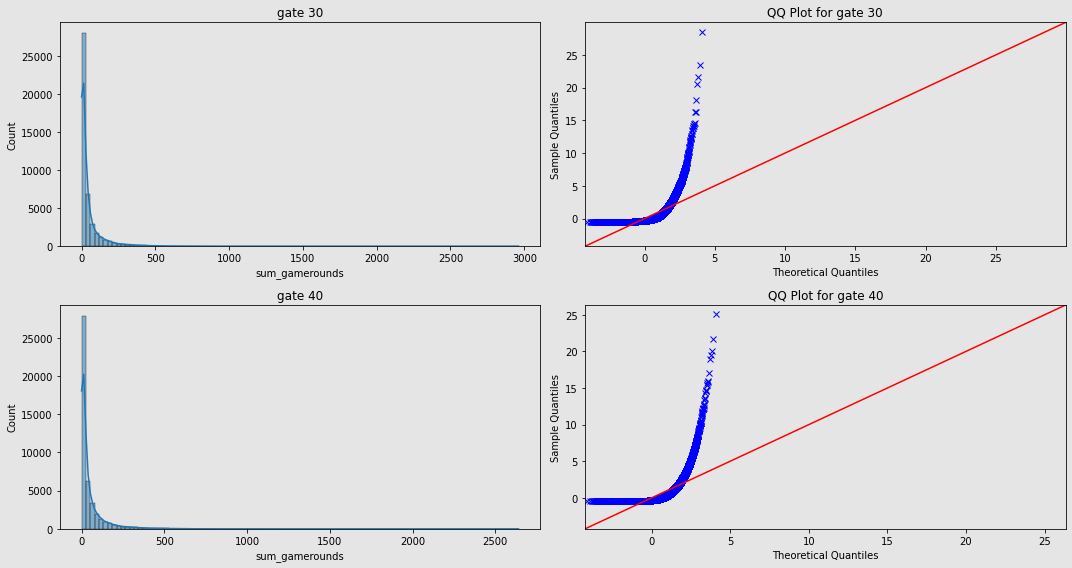

In [14]:
fig, axes = plt.subplots(2, 2, figsize = (15, 8), facecolor = "#e5e5e5")
axes = axes.ravel()

for ax in axes:
    ax.set_facecolor("#e5e5e5")

sns.histplot(data = df[df.version == "gate_30"], x = "sum_gamerounds", 
             ax = axes[0], bins = 100, kde = True).set_title("gate 30")
sns.histplot(data = df[df.version == "gate_40"], x = "sum_gamerounds", 
             ax = axes[2], bins = 100, kde = True).set_title("gate 40")

with warnings.catch_warnings():
    
    warnings.simplefilter("ignore")
    
    sm.qqplot(df[df.version == "gate_30"].sum_gamerounds, ax = axes[1], 
              marker = "x", line = "45", fit = True)
    sm.qqplot(df[df.version == "gate_40"].sum_gamerounds, ax = axes[3], 
              marker = "x", line = "45", fit = True)
        
axes[1].set_title("QQ Plot for gate 30")
axes[3].set_title("QQ Plot for gate 40")

plt.tight_layout()
plt.show()

[take me to the top](#section-top)

<a id="section-three-two"></a>
## 3.2 Checking Normality with Statistical Tests

We know, sum_gamerounds variable has right-skewed distribution. It is far away from normality. We know it from kdeplot, histplot and, qq plot. Let's proove it with statistical tests.

I just define below function for checking normality.

This function takes a series as input, prints hypothesis, skewness, kurtosis. Applies a normality test for its sample size and prints result.

*For N > 5000 the W test statistic is accurate but the p-value may not be.
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html

In [15]:
def check_normality(series, alpha = 0.05):
    
    print(f"\nH0: {series.name} is normally distributed")
    print(f"H1: {series.name} is not normally distributed \n")
    print(f"Skewness for {series.name} is {series.skew().round(3)} "
          f"and kurtosis is {series.kurtosis().round(3)} \n")
    
    if len(series) <= 5000:
        print("Performing Shapiro–Wilk test")
        statistic, pvalue = stats.shapiro(series)
        
        print(f"Shapiro Test Statistic \t {round(statistic, 5)}")
        print(f"p-value \t {pvalue}")  
        
    else:
        print("Performing D'Agostino's K2 test")
        statistic, pvalue = stats.normaltest(series)
        print(f"Test Statistic \t {round(statistic, 5)}")
        print(f"p-value \t {pvalue}") 
        
    
    if pvalue <= alpha: 
        print("\nWe can reject null hypothesis, "
              "so that our series is not normally distributed.")
        
    else: 
        print("\nWe can't reject null hypothesis, "
              "so that our series is normally distributed.")
        
    result = "Not Normal"
    
    return result

In [16]:
print("\033[1m\nsum_gamerounds normality for both version: \n\033[0m")

check_normality(df["sum_gamerounds"])


sum_gamerounds normality for both version: 


H0: sum_gamerounds is normally distributed
H1: sum_gamerounds is not normally distributed 

Skewness for sum_gamerounds is 5.954 and kurtosis is 65.267 

Performing D'Agostino's K2 test
Test Statistic 	 104181.60505
p-value 	 0.0

We can reject null hypothesis, so that our series is not normally distributed.


'Not Normal'

In [17]:
gate30 = df[df.version == "gate_30"]
gate40 = df[df.version == "gate_40"]

In [18]:
print("\033[1msum_gamerounds normality for gate 30: \n\033[0m")

check_normality(gate30["sum_gamerounds"])

sum_gamerounds normality for gate 30: 


H0: sum_gamerounds is normally distributed
H1: sum_gamerounds is not normally distributed 

Skewness for sum_gamerounds is 5.94 and kurtosis is 67.563 

Performing D'Agostino's K2 test
Test Statistic 	 51730.04355
p-value 	 0.0

We can reject null hypothesis, so that our series is not normally distributed.


'Not Normal'

In [19]:
print("\033[1msum_gamerounds normality for gate 40: \n\033[0m")

check_normality(gate40["sum_gamerounds"])

sum_gamerounds normality for gate 40: 


H0: sum_gamerounds is normally distributed
H1: sum_gamerounds is not normally distributed 

Skewness for sum_gamerounds is 5.967 and kurtosis is 63.106 

Performing D'Agostino's K2 test
Test Statistic 	 52497.05167
p-value 	 0.0

We can reject null hypothesis, so that our series is not normally distributed.


'Not Normal'

[take me to the top](#section-top)

<a id="section-four"></a>

# 4. Comparing Groups: sum_gamerounds

We don't have normal distributed variable. (Non-Parametric) For that reason, I will apply Mann Whitney U test for comparing our groups.

If we have normal distributed variable, we can perform parametric tests. In this problem, it is t-test.

Below function simply, takes two series and performs Mann Whitney U for comparison. It just prints hypothesis, statistics and results.

**Assumptions for the Mann Whitney U Test**

- The dependent variable should be measured on an ordinal scale or a continuous scale.

- The independent variable should be two independent, categorical groups.

- Observations should be independent. In other words, there should be no relationship between the two groups or within each group.

- Observations are not normally distributed. However, they should follow the same shape (i.e. both are bell-shaped and skewed left).

*https://www.statisticshowto.com/mann-whitney-u-test/

In [20]:
def test_mannwhitneyu(series1, series2, alpha = 0.05):
    
    print("H0: Distributions of both populations are equal.")
    print("H1: Distributions of both populations are not equal.\n")
    
    statistic, pvalue = stats.mannwhitneyu(series1, series2)
    
    print(f"Mann Whitney U test statistic is {statistic.round(5)}")
    print(f"p-value for Mann Whitney U is {pvalue}")
    
    
    print(f"\nFor alpha = {alpha}")
    
    if pvalue <= alpha:
        print("We can reject null hypothesis. These groups are not similar.")
    else:
        print("We can not reject null hypothesis. These groups are similar.")              

In [21]:
test_mannwhitneyu(gate30["sum_gamerounds"], gate40["sum_gamerounds"])

H0: Distributions of both populations are equal.
H1: Distributions of both populations are not equal.

Mann Whitney U test statistic is 1024285761.5
p-value for Mann Whitney U is 0.05089155279145376

For alpha = 0.05
We can not reject null hypothesis. These groups are similar.


[take me to the top](#section-top)

<a id="section-five"></a>

# 5. Comparing Groups: retention days

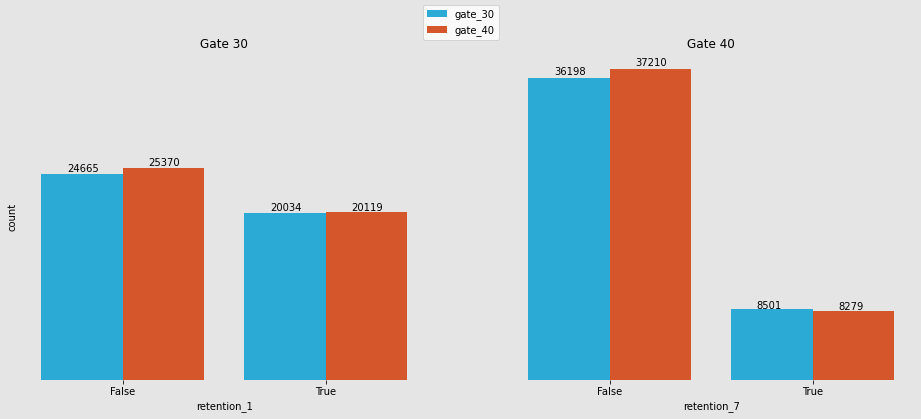

In [22]:
fig, axes = plt.subplots(1, 2, figsize = (16, 6), facecolor = "#e5e5e5", sharey = True)

sns.countplot(x = "retention_1", data = df, hue = "version",
              ax = axes[0], palette = ["#0EB8F1", "#F1480F"]).set_title("Gate 30")

sns.countplot(x = "retention_7", data = df, hue = "version",
              ax = axes[1], palette = ["#0EB8F1", "#F1480F"]).set_title("Gate 40")

for ax in axes:
    
    ax.set_facecolor("#e5e5e5")
    ax.get_legend().remove()
    ax.set_yticks([])
    
    for p in ax.patches:
        
        txt = p.get_height()
        ax.text(p.get_x() + 0.125, p.get_height()*1.01, txt, fontsize = 10)
        
axes[1].set_ylabel("")
        
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc = "upper center")

sns.despine(left = True, bottom = True)
plt.show()

## Chi-Square Test of Independence

The Chi-Square Test of Independence determines whether there is an association between categorical variables (i.e., whether the variables are independent or related). It is a nonparametric test.

https://libguides.library.kent.edu/spss/chisquare

**Assumptions**

1) Two categorical variables.

2) Two or more categories (groups) for each variable.

3) Independence of observations.

- There is no relationship between the subjects in each group.

- The categorical variables are not "paired" in any way (e.g. pre-test/post-test observations).

4) Relatively large sample size.

- Expected frequencies for each cell are at least 1.

- Expected frequencies should be at least 5 for the majority (80%) of the cells.

https://libguides.library.kent.edu/spss/chisquare

For performing Chi-Square test, we need contingency table. Contingency table is simply, tabular representation of categorical variables.

In pandas, we can create contingency table with using pd.crosstab.

In [23]:
cross1 = pd.crosstab(df["version"], df["retention_1"])
cross1

retention_1,False,True
version,,
gate_30,24665,20034
gate_40,25370,20119


In [24]:
cross7 = pd.crosstab(df["version"], df["retention_7"])
cross7

retention_7,False,True
version,,
gate_30,36198,8501
gate_40,37210,8279


I define a simple function for chi2 test. This function takes contingency table as input, prints hypothesis, test statistics and returns its result.

In [25]:
def test_chi2(crosstable, alpha = 0.05):
    
    print("H0: Variable 1 and Variable 2 are independent. "
          "Version and retention day are independent.")
    print("H1: Variable 1 and Variable 2 are dependent. "
          "Version and retention day are dependent. \n")
    
    chi2, p, dof, expected = stats.chi2_contingency(crosstable, correction = False)
    chi2, p, dof, expected 
    
    print("Observed frequencies: ")
    display(crosstable)
    
    print(f"Chi-square test statistic is {chi2}")
    print(f"p value for test is {p}")
    print(f"Degrees of freedom (num rows - 1) * (num columns - 1) is {dof}")
    
    print(f"\nExpected frequencies: ")
    display(pd.DataFrame(expected, index = ["gate_30", "gate_40"]))
    
    if p <= alpha:
        print(f"\nWe can reject null hypothesis for {alpha} significance level. " 
              "There is a statistically significant relation between version and retention.")
    else:
        print(f"\nWe can not reject null hypothesis for {alpha} significance level. "
              "There is no statistically significant relation between version and retention.")

In [26]:
print("\033[1mChi-sqaure test for version and retention_1\033[0m:\n")
test_chi2(cross1)

Chi-sqaure test for version and retention_1:

H0: Variable 1 and Variable 2 are independent. Version and retention day are independent.
H1: Variable 1 and Variable 2 are dependent. Version and retention day are dependent. 

Observed frequencies: 


retention_1,False,True
version,,
gate_30,24665,20034
gate_40,25370,20119


Chi-square test statistic is 3.19373895460949
p value for test is 0.07392076034183397
Degrees of freedom (num rows - 1) * (num columns - 1) is 1

Expected frequencies: 


,0,1
gate_30,24798.359704,19900.640296
gate_40,25236.640296,20252.359704



We can not reject null hypothesis for 0.05 significance level. There is no statistically significant relation between version and retention.


In [27]:
print("\033[1mChi-sqaure test for version and retention_7\033[0m \n")
test_chi2(cross7)

Chi-sqaure test for version and retention_7 

H0: Variable 1 and Variable 2 are independent. Version and retention day are independent.
H1: Variable 1 and Variable 2 are dependent. Version and retention day are dependent. 

Observed frequencies: 


retention_7,False,True
version,,
gate_30,36198,8501
gate_40,37210,8279


Chi-square test statistic is 9.96923845042939
p value for test is 0.0015917731773992998
Degrees of freedom (num rows - 1) * (num columns - 1) is 1

Expected frequencies: 


,0,1
gate_30,36382.492039,8316.507961
gate_40,37025.507961,8463.492039



We can reject null hypothesis for 0.05 significance level. There is a statistically significant relation between version and retention.


[take me to the top](#section-top)

<a id="section-five-one"></a>

## 5.1 Chi-Square Tests Results

First, we compare version and one day retention (retention_1). For Chi-Square independence test, our p-value is 0.07.

We can say that, for 0.05 alpha, there is no statistically significant relation between version and one day retention.

Secondly, we compare version and seven day retention (retention_7). For Chi-Squre independence test, our p-value is 0.001.

We can say that, for 0.05 alpha, there is a statistically significant relation between version and seven day retention.

[take me to the top](#section-top)

<a id="section-six"></a>

# 6. Conclusion

If we need to summarise briefly;

We apply **Mann Whitney U** test for comparing sum_gamerounds for both version. 

For Mann Whitney U test, we don't have statistically significant difference between groups. They have similar sum_gamerounds.


For retention days,

We apply **Chi-Square Independence test** for comparing the relation between version and retention day.

For Chi-Square test; there is no statistically significant relation between one day retention and mobile game version.

But, there is a statistically significant relation between seven day retention and mobile game version.

In [28]:
df.groupby("version")[["sum_gamerounds", "retention_1", "retention_7"]].mean()

,sum_gamerounds,retention_1,retention_7
version,,,
gate_30,51.342111,0.448198,0.190183
gate_40,51.298776,0.442283,0.182000


[take me to the top](#section-top)